# Forecasting Run Expectancy Per Inning
**Goal:** Build a model that predicts expected runs scored *in an inning* for a batting team, using batter-level features (batter in batting rotation), contextual game features, and fielder defensive contribution (WAR). Run MC simulations of innings with simple logistic regression to sample for outcomes of at bats

**Notebook structure**
1. Config / params (easy-to-edit)
2. Data ingestion (pybaseball)
3. Feature engineering (batter-level + context + fielding WAR)
4. Create target: runs scored within an inning (team-inning)
5. Train/test splits
6. Markov state space model with logistic regression for transition probabilities
7. Evaluation: RMSE, MAE, coverage of CIs, calibration plots, example inning-level comparisons vs. observed
8. Notes on pitfalls, extensions, and alternatives


In [214]:
# Basic imports and configuration
import os
import numpy as np
import pandas as pd
from datetime import datetime
from joblib import Memory
import warnings

from pybaseball import statcast

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#Pybaseball
from pybaseball import statcast, statcast_batter, playerid_lookup, batting_stats, batting_stats_range, statcast_pitcher
from pybaseball import pitching_stats, team_pitching, team_batting, schedule_and_record
    


# For saving / reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Make plotting look reasonable
plt.rcParams['figure.figsize'] = (10,5)


In [ ]:
# Configurable parameters
START = '2024-03-01'   # start of data pull window 
END   = '2024-11-01'   # end of data pull window
MIN_PLATE_APPEARANCES = 50    # threshold for batter-season aggregation
TEST_SIZE = 0.2
GP_N_SAMPLES = 2000           # Monte Carlo samples for predictive distribution





In [ ]:
# Caching directory
CACHE_DIR = "./cache"
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

memory = Memory(CACHE_DIR, verbose=1)

@memory.cache
def fetch_statcast(start_date, end_date):
    """Fetches Statcast with disk caching."""
    return statcast(start_date,end_date)

df_core = fetch_statcast(START, END)


________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-nikita-AppData-Local-Temp-ipykernel-398842597.fetch_statcast...
fetch_statcast('2024-03-01', '2024-11-01')
This is a large query, it may take a moment to complete


C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


  0%|          | 0/232 [00:00<?, ?it/s]

C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

_________________________________________________fetch_statcast - 215.1s, 3.6min


KeyError: "['game_id'] not in index"

In [196]:
NEEDED = [
    "game_pk", "game_date",
    "batter", "pitcher", "stand",
    "inning", "outs_when_up",
    "on_1b", "on_2b", "on_3b",
    "events"]

df = df_core[NEEDED].dropna(subset=["batter"]).copy()

# Drop missing rows
df = df.dropna(subset=["batter", "pitcher","events"])
df.columns

Index(['game_pk', 'game_date', 'batter', 'pitcher', 'stand', 'inning',
       'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'events'],
      dtype='object')

In [328]:
df[["game_pk","inning"]].head()

,game_pk,inning
0,744795,1
1,744795,1
2,744795,1
3,744795,1
5,744795,2


In [201]:
#encode base states via bitmasking

df["base_state"] = (
    df["on_1b"].notna().astype(int)
    + 2 * df["on_2b"].notna().astype(int)
    + 4 * df["on_3b"].notna().astype(int)
)

df["base_state"].value_counts()

base_state
0    112180
1     36194
2     16724
3     13168
5      5449
4      5307
6      4544
7      4416
Name: count, dtype: int64

In [199]:
df["events"].value_counts()

events
field_out                    79520
strikeout                    44736
single                       28071
walk                         15771
double                        8446
home_run                      5913
force_out                     3761
grounded_into_double_play     3488
hit_by_pitch                  2200
sac_fly                       1352
field_error                   1239
triple                         767
intent_walk                    530
sac_bunt                       473
fielders_choice                426
double_play                    366
truncated_pa                   351
fielders_choice_out            325
strikeout_double_play          120
catcher_interf                 110
sac_fly_double_play             15
triple_play                      2
Name: count, dtype: int64

In [ ]:
# simplifies events into broader categories

def map_event(outcome):
    if outcome in [
        "strikeout", "field_out", "force_out",
        "fielders_choice", "fielders_choice_out"]:
        return "OUT"

    if outcome in ["double_play", "triple_play", "sac_fly_double_play", "grounded_into_double_play", "strikeout_double_play"]:
        return "2OUT"

    if outcome in ["single", "field_error"]:
        return "SINGLE"

    if outcome in ["double"]:
        return "DOUBLE"
    
    if outcome in ["triple"]:
        return "TRIPLE"

    if outcome == "home_run":
        return "HR"

    if outcome in ["walk", "intent_walk", "hit_by_pitch", "catcher_interf"]:
        return "BB"

    if outcome in ["sac_bunt", "sac_fly"]:
        return "SAC"

    # Anything else → treat as OUT
    return "OUT"

df["events"] = df["events"].apply(map_event)

In [ ]:
#batter stats calculation
df = df.sort_values(["game_pk", "inning"]).reset_index(drop=True)


hit_events = ["SINGLE", "DOUBLE", "TRIPLE", "HR"]
df["is_hit"] = df["events"].isin(hit_events).astype(int)
df["is_ab"] = (~df["events"].isin(["BB"])).astype(int) #at bat definition: plate appearances excluding walks

def add_rolling_stats(g):
    g["cum_ab"] = g["is_ab"].cumsum()
    g["cum_hits"] = g["is_hit"].cumsum()
    g["OBP"] = g["cum_hits"] / g["cum_ab"].replace(0, np.nan)
    return g

df = df.groupby("batter", group_keys=False).apply(add_rolling_stats)




C:\Users\nikita\AppData\Local\Temp\ipykernel_9884\3211246433.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("batter", group_keys=False).apply(add_rolling_stats)


In [ ]:
def compute_runs_scored(prev_base_state, event):
    """
    Compute runs scored from a plate appearance and update base state and outs
    
    Args:
        prev_base_state (int): 3-bit base state before the PA (0-7)
        event (str or float): Statcast event type (after outcome grouping); may be NaN
    Returns:
        tuple: new_base_state (int 0-7), runs_scored (int 0-4), new_resulting_outs (0,1,2) (triple plays not considered due to raririty)
    """
    # Treat NaN events as no advancement / no runs
    if not isinstance(event, str):
        return (prev_base_state,0,0)

    prev_base_state=int(prev_base_state)

    # Home run: batter + all runners score
    if event == "HR":
        return (0,1 + prev_base_state.bit_count(),0)
    

    if event in ["OUT", "SAC"]:
        return (prev_base_state,0,1)
    elif event=="2OUT":

        dp_dict={
            0:0,
            1:0,
            2:0,
            3:1,
            4:0,
            5:1,
            6:2,
            7:3
        }

        return (dp_dict[prev_base_state],0,2)

    walk_dict={
        0:1,
        1:3,
        2:3,
        3:7,
        4:5,
        5:7,
        6:7,
        7:7
    }

    if event=="BB": #batter takes their base
        return ((7,1,0) if prev_base_state==7 else (walk_dict[prev_base_state],0,0)) #batter takes their base on bases loaded

    
    if event=="SAC":
        return ((2*prev_base_state)%8, (2*prev_base_state)//8,1)

    advance_dict={
        "SINGLE":1,
        "DOUBLE":2,
        "TRIPLE":3
    }
    advance=advance_dict.get(event, 0)

    
    advanced_state=prev_base_state*(2**advance)+2**(advance-1)
    return (advanced_state%8,(advanced_state//8).bit_count(),0)



(4, 0, 0)

In [ ]:
#create features for batter order at each PA
# Batter order proxy
# Create plate appearance number within each game
df["pa_number"] = df.groupby("game_pk").cumcount()

# Batter index cycles through lineup (0-8)
df["batter_index"] = df["pa_number"] % 9

# Compute next state safely
# Sort by game, inning, and plate appearance
df = df.sort_values(["game_pk", "inning", "pa_number"]).reset_index(drop=True)

# Shift within each game and inning group
df["next_outs"] = df.groupby(["game_pk", "inning"])["outs_when_up"].shift(-1)
df["next_bases"] = df.groupby(["game_pk", "inning"])["base_state"].shift(-1)
df["next_batter_index"] = df.groupby(["game_pk", "inning"])["batter_index"].shift(-1)

# Drop rows where there is no next PA in the same inning
df = df.dropna(subset=["next_outs", "next_bases", "next_batter_index"])

# Compute actual outs per PA
# Base out-event detection
df["out_event"] = df["events"].str.contains(
    "out",
    case=False, na=False
).astype(int)

# Double plays
df.loc[df["events"].str.contains("double_play", case=False, na=False), "out_event"] = 2

# Triple plays
df.loc[df["events"].str.contains("triple_play", case=False, na=False), "out_event"] = 3


np.int64(79592)

In [ ]:
# compute outs per pa and run scored per inning per pitcher

# Compute delta-outs and runs
# d_outs = actual outs recorded in this PA
df["d_outs"] = df["out_event"]

df["run_scored_per_pa"]= df.apply(
    lambda row: compute_runs_scored(
        row["base_state"],
        row["events"]
    )[1],
    axis=1
)

#sum up runs per inning per pitcher
df["run_scored"] = (
    df.groupby(["game_pk", "inning", "pitcher"])["run_scored_per_pa"]
      .transform("sum")
)



In [ ]:
#compute fielding strength feature from player WAR data

if "stand_enc" not in df.columns:
    df["stand_enc"] = df["stand"].map({"R": 1, "L": 0}).fillna(0).astype(int)

FIELDING_COLS = [c for c in df.columns if "WAR" in c.lower()]

if len(FIELDING_COLS) > 0:
    df["fielding_strength"] = df[FIELDING_COLS].sum(axis=1)
    print("fielding strength calculated")
else:
    # fallback
    df["fielding_strength"] = 0



In [ ]:
#perform label encoding on features relevant to predicting PA events

from sklearn.preprocessing import LabelEncoder


FEATURES = [
    "OBP",
    "stand_enc",
    "outs_when_up",
    "base_state",        
    "fielding_strength",
    "events"
]

X = df[FEATURES].dropna()
le = LabelEncoder()
y = le.fit_transform(X["events"])     # fit on ALL states
X=X.drop(columns=["events"])

num_classes = len(le.classes_)

FEATURES.remove("events")


In [ ]:
#0.8 to 0.1 to 0.1 split for train-test-validation

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_val_scaled  = scaler.transform(X_val)


In [ ]:
#fill in missing stats for training

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)

In [ ]:
#train model to predict outcome of PA with class weight balancing

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=200,
    multi_class="multinomial",
    n_jobs=-1,
    class_weight="balanced"
)

# Fit on train; provide the full class list
clf.fit(
    X_train_scaled,
    y_train,
    sample_weight=None,
)

# Manually store full class list
clf.all_classes_ = le.classes_


C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
#event prediction model validation

from sklearn.metrics import log_loss, accuracy_score, classification_report


def expand_proba(proba_small, trained_classes):
    """
    Handles both:
        (N_classes,)       -> single row
        (N_samples,N_classes) -> batch
    """
    proba_small = np.asarray(proba_small)

    # CASE 1: single sample vector
    if proba_small.ndim == 1:
        full = np.zeros(num_classes)
        full[trained_classes] = proba_small
        return full

    # CASE 2: batch (N_samples x N_classes)
    N = proba_small.shape[0]
    full = np.zeros((N, num_classes))
    full[:, trained_classes] = proba_small
    return full




# Predict probabilities and labels
val_pred_proba = clf.predict_proba(X_val_scaled)


val_pred_proba_full = expand_proba(
    val_pred_proba,
    clf.classes_
)



val_logloss = log_loss(
    y_val,
    val_pred_proba_full,
    labels=np.arange(num_classes)
)

val_pred       = clf.predict(X_val_scaled)

val_acc     = accuracy_score(y_val, val_pred)

print("====== Validation Results ======")
print(f"Log-loss:   {val_logloss:.4f}")
print(f"Accuracy:   {val_acc:.4f}")



print("\nClassification report:\n")
y_val_str  = le.inverse_transform(y_val)
y_pred_str = le.inverse_transform(val_pred)

# Full list of original class names
target_names = list(le.classes_)

# Print report
print(classification_report(
    y_val_str,
    y_pred_str,
    labels=target_names,
    target_names=target_names
))

====== Validation Results ======
Log-loss:   1.9777
Accuracy:   0.2176

Classification report:

              precision    recall  f1-score   support

        2OUT       0.03      0.37      0.06       259
          BB       0.10      0.06      0.08      1219
      DOUBLE       0.08      0.10      0.09       547
          HR       0.00      0.00      0.00       380
         OUT       0.71      0.27      0.39      8155
         SAC       0.10      0.81      0.19       144
      SINGLE       0.17      0.09      0.12      1851
      TRIPLE       0.00      0.28      0.01        50

    accuracy                           0.22     12605
   macro avg       0.15      0.25      0.12     12605
weighted avg       0.50      0.22      0.29     12605



C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_c

In [ ]:
#simulate an inning running through batter rotation order and updating base/out state using prediction model

def simulate_inning(i, clf, scaler, df):
    """
    Simulate a single inning using a Markov chain starting from row i in df.

    Parameters
    ----------
    i : int
        Row index in df to start the inning.
    clf : trained sklearn classifier
        Predicts transition probabilities.
    scaler : fitted StandardScaler
        For scaling the feature vector.
    df : pandas.DataFrame
        Must contain columns:
            - 'outs_when_up', 'base_state', 'batter_index'
            - all features listed in FEATURES

    Returns
    -------
    runs : int
        Total runs scored in this simulated inning.
    """
    # Extract initial state
    row = df.iloc[i]
    #outs = int(row["outs_when_up"])
    #base_state = int(row["base_state"])
    outs = 0
    base_state = 0
    batter_idx = int(row["batter_index"])
    
    # Precompute feature vectors per batter to avoid full dataframe access each time
    unique_batters = df['batter_index'].unique()
    batter_features = {
        bidx: df[df['batter_index'] == bidx].iloc[0][FEATURES].values
        for bidx in unique_batters
    }
    
    runs = 0
    max_pa = 50  # safety to avoid infinite loop
    
    global total_outs, total_pa

    for _ in range(max_pa):
        if outs >= 3:
            break

        # ----- Get feature vector for current batter -----
        X_row = batter_features[batter_idx].reshape(1, -1)
        X_row = imputer.transform(X_row.reshape(1, -1))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X_scaled = scaler.transform(X_row)
        
        # ----- Predict transition probabilities -----
        probs_pred = clf.predict_proba(X_scaled)[0]
        observed_classes = clf.classes_

        
        outcome_event =  le.inverse_transform([np.random.choice(observed_classes, p=probs_pred)])[0]
      
        base_state, RBI, new_outs = compute_runs_scored(base_state , outcome_event)
        
        runs+=RBI
        outs+=new_outs
        batter_idx = (batter_idx + 1) % len(unique_batters)

        total_pa+=1
        total_outs+=new_outs
                
    return runs


In [ ]:
#simulate a 1000 innings and report mean and se of runs per inning

NUM_SIM = 1000

total_outs =0
total_pa = 0

simulated = [
    simulate_inning(i, clf, scaler, df)
    for i in range(NUM_SIM)
]

print(f"Mean simulated runs/inning: {np.mean(simulated):.3f}")
print(f"SE simulated runs/inning: {np.sqrt(np.var(simulated)):.3f}")
print(f"out percentage: {total_outs/total_pa:.3f}")


C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pa

Mean simulated runs/inning: 1.192
SE simulated runs/inning: 1.807
out percentage: 0.678


C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pa

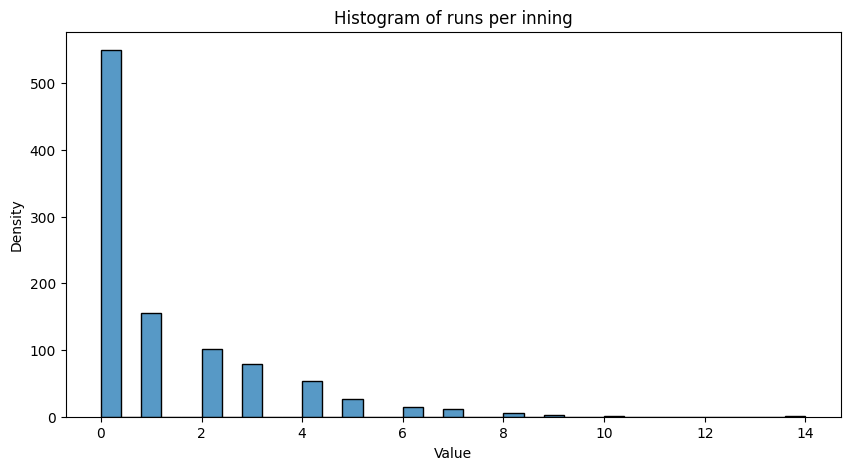

<Axes: xlabel='run_scored', ylabel='Count'>

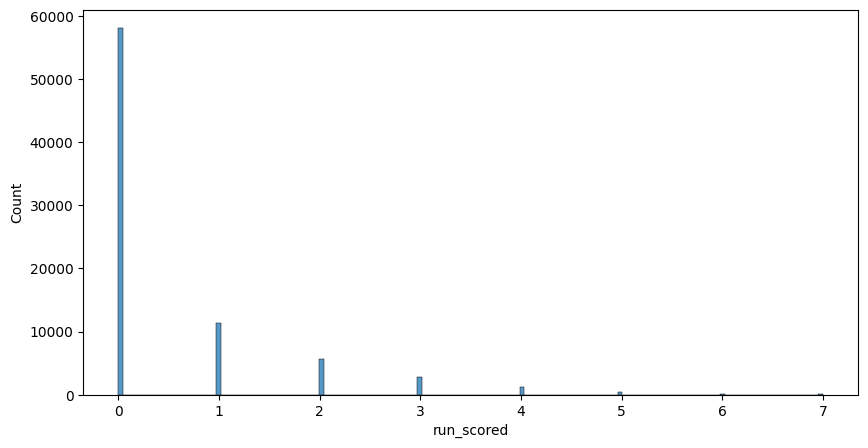

In [ ]:
#plot distribution of runs scored per inning in simulation vs actual data

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=simulated)
plt.title("Histogram of runs per inning")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

sns.histplot(data=df["run_scored"])
